# Creating a Gravest Empirical Mode (GEM) field of the standing meander

In [1]:
%run ../../_setup.py

import numpy as np
from netCDF4 import Dataset
from scipy.interpolate import UnivariateSpline, LinearNDInterpolator
import cmocean as cmo
import matplotlib.pyplot as plt

Load ctd data and show variables stored in NetCDF file

In [2]:
# load ctd and gsw data
input_file = os.path.join(datadir, 'processed', 'ss9802', 'netcdf', 'ss9802_ctd_gsw.nc')
ctd = Dataset(input_file, 'r')
ctd.variables.keys()

odict_keys(['ts_lat', 'station', 'depth', 'bot_lat', 't', 'lat', 'bot_lon', 'O2', 'ts_t', 'SP', 'time', 'lon', 'ts_SP', 'p', 'ts_lon', 'ts_O2', 'latv', 'pt', 'SA', 'Vg', 'spiciness0', 'lonv', 'z', 'g', 'CT', 'deltaD', 'sigma0', 'gamman'])

Create Dynamic Height contours with the reference level (1494 dbar) considered as the level of 'no-motion'

In [3]:
# find indices for pressure levels in CTD prodiles
pressure_levels = {}
for ip, p in enumerate(ctd['p'][:]):
    pressure_levels[p] = ip

# define reference and interest level 
# p_ref = 1494
p_int = 2

# get dynamic height contours
D = np.array([ctd['deltaD'][profile, pressure_levels[p_int]] / 
              ctd['g'][profile, pressure_levels[p_int]]
              for profile in range(len(ctd.dimensions['profile']))])


/home/janjaapmeijer/miniconda3/envs/ocean3/lib/python3.5/site-packages/ipykernel_launcher.py:13: UserWarning: Warning: converting a masked element to nan.
  del sys.path[0]


Fit a spline function for the various variables at each depth level 

In [5]:
odds = [1, 2, 9, 10, 11, 12, 27, 45, 46, 47, 75, 76, 77, 78, 101]
iodds = [istat for istat, station in enumerate(ctd['station']) if station in odds]

vars = ['CT', 'SA', 'sigma0']
splines = {}

xinterp = np.linspace(np.nanmin(D[2:]), np.nanmax(D[2:]), 100)
for p in ctd['p'][:]:
    splines[p] = {}
    for var in vars:
        mask = np.ma.masked_where((np.isnan(D)) | (np.ma.masked_invalid(ctd[var][:, pressure_levels[p]]).mask) | 
                                  ([station in odds for station in ctd['station']]), D).mask
        try:
            x, y = zip(*sorted(zip(D[~mask][2:], ctd[var][:, pressure_levels[p]][~mask][2:])))
            splines[p][var] = UnivariateSpline(x, y)
        except:
            splines[p][var] = []


Plot the spline functions and indicate the outliers in yellow, the outliers are excluded from the interpolation.

/home/janjaapmeijer/miniconda3/envs/ocean3/lib/python3.5/site-packages/ipykernel_launcher.py:3: UserWarning: Warning: converting a masked element to nan.
  This is separate from the ipykernel package so we can avoid doing imports until


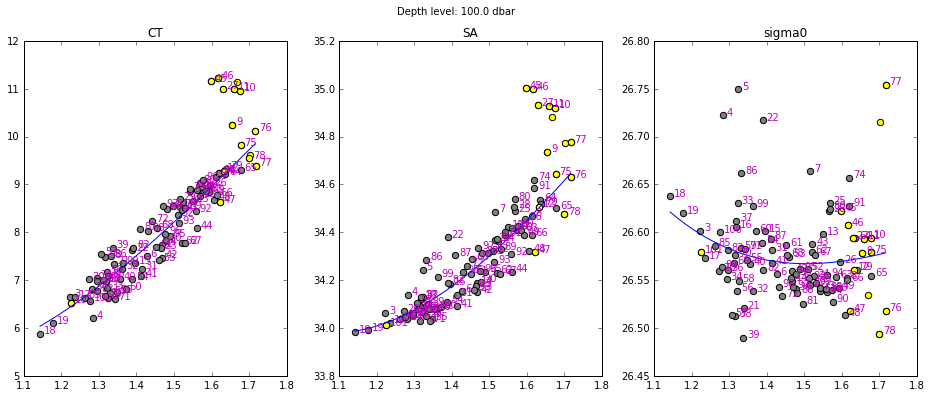

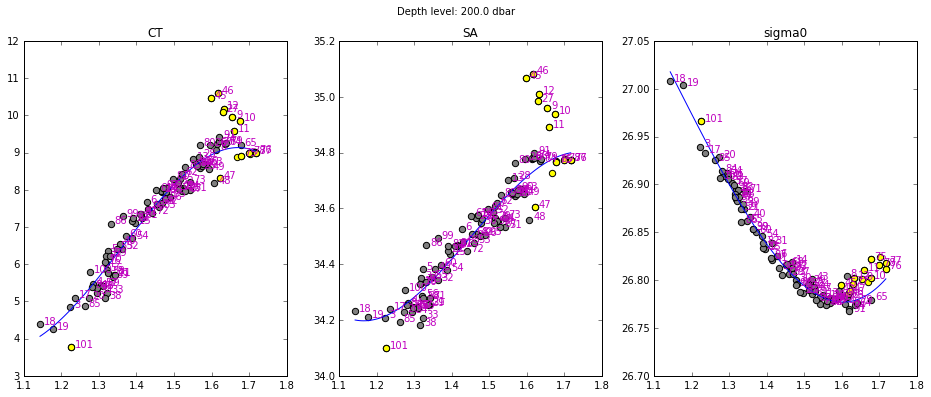

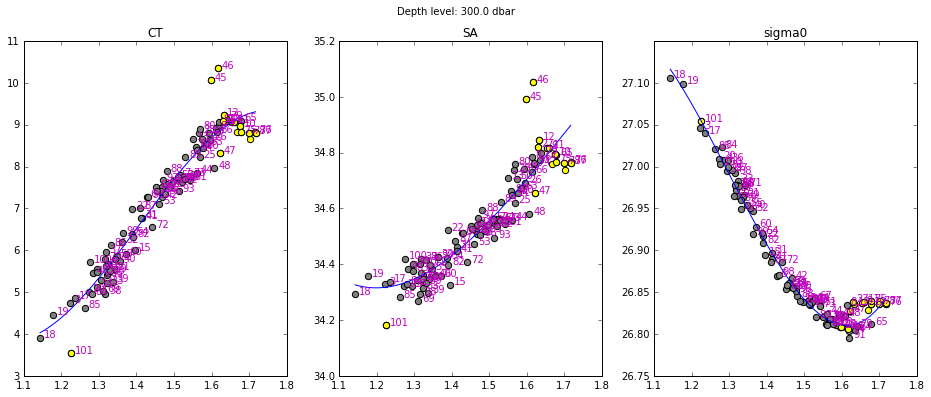

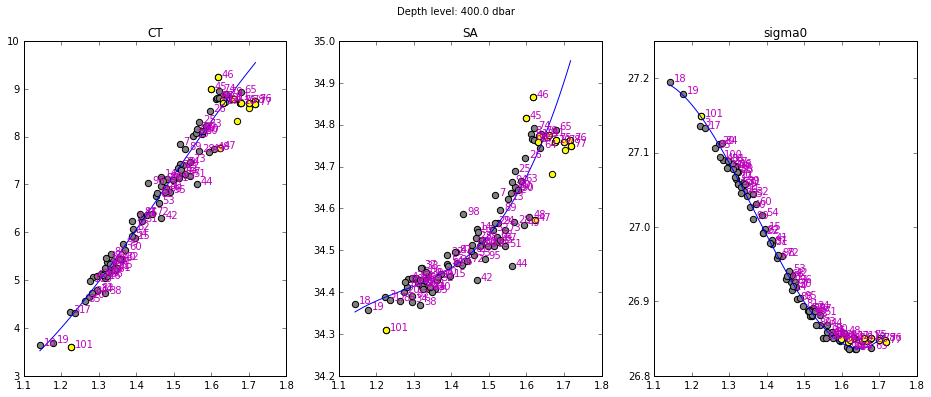

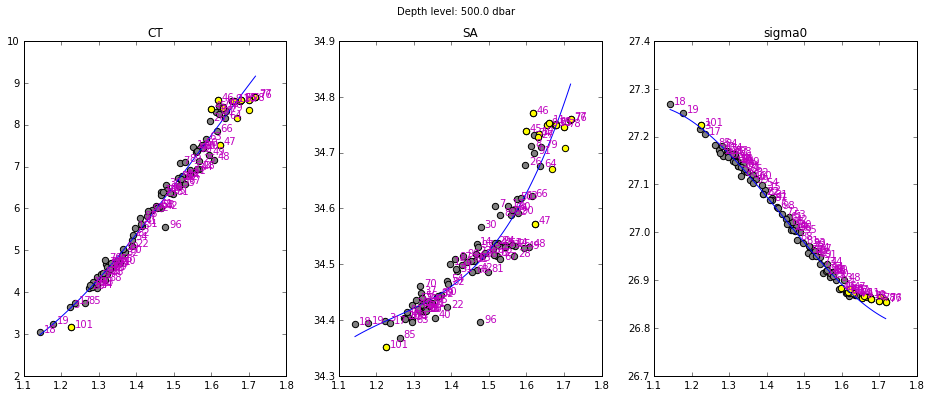

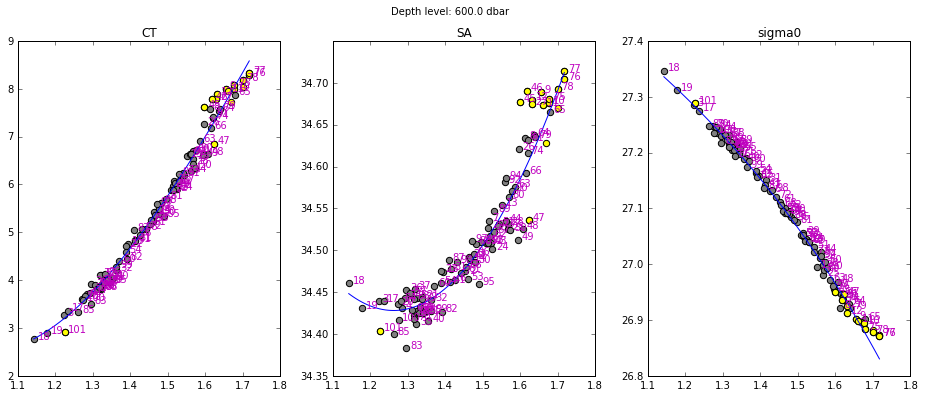

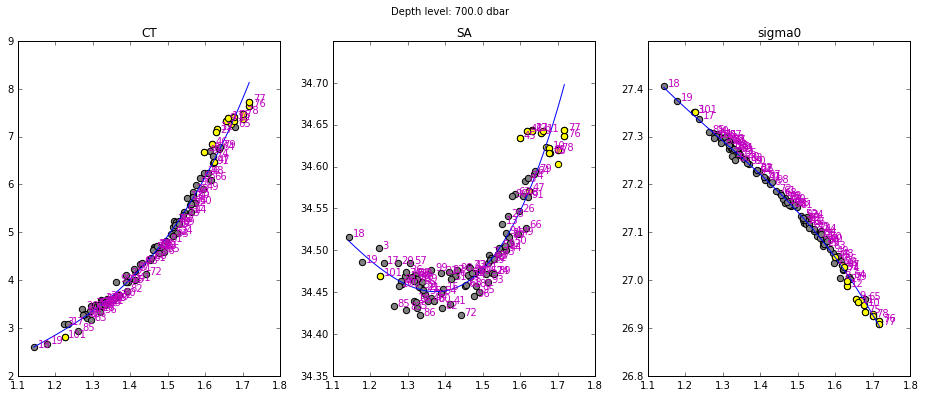

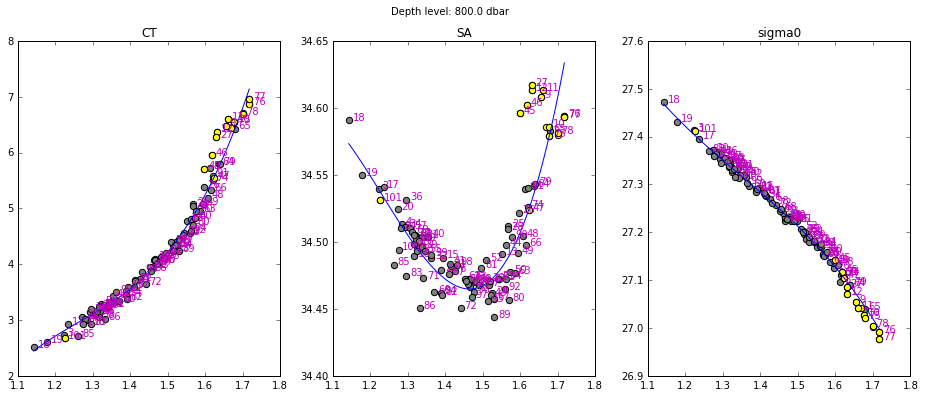

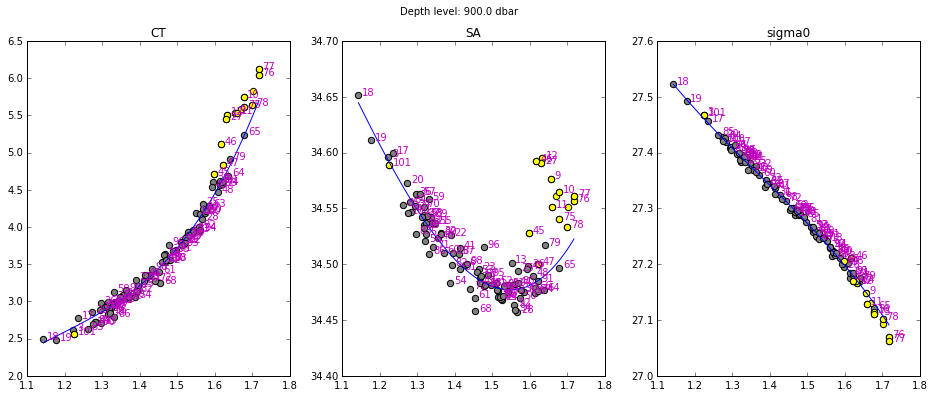

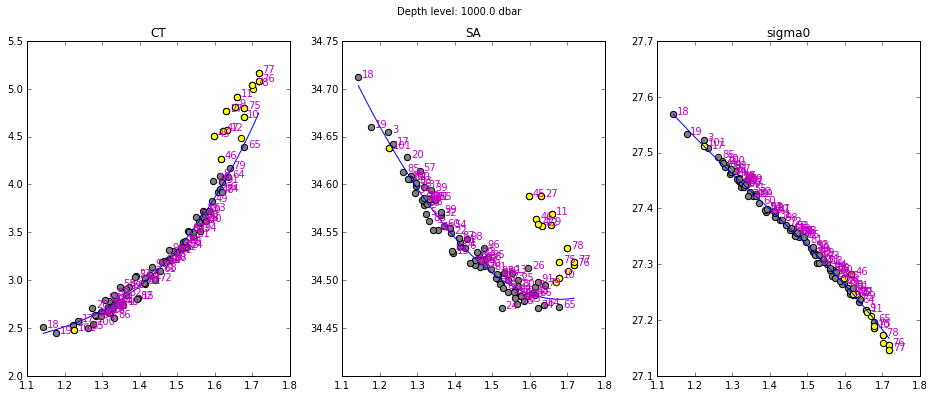

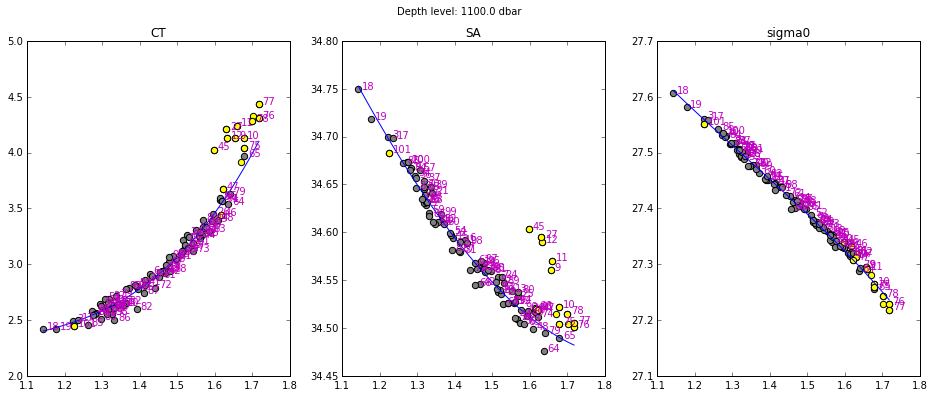

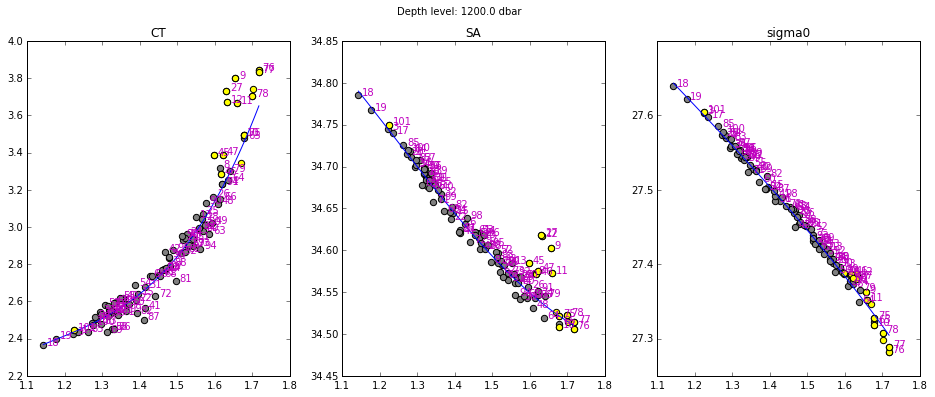

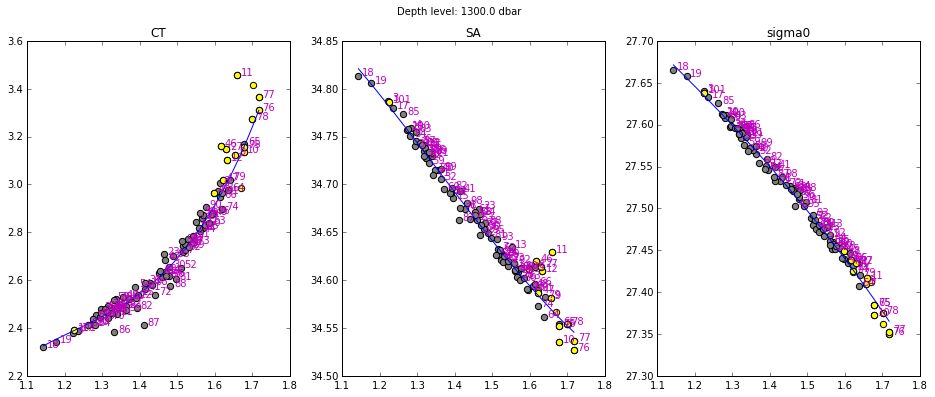

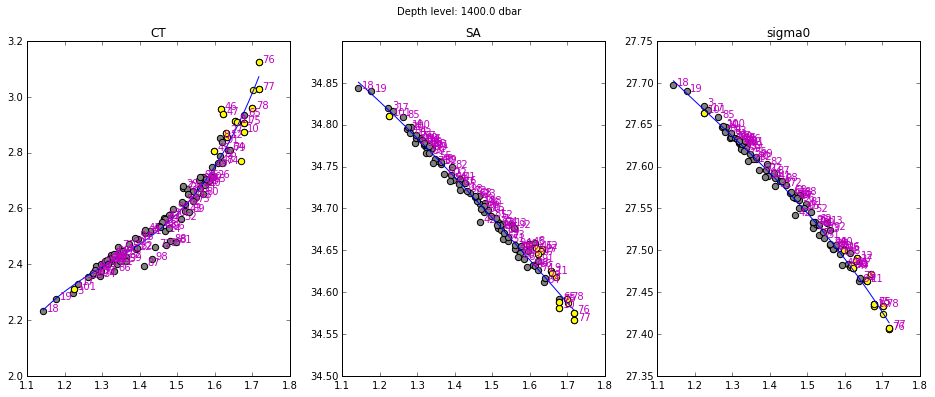

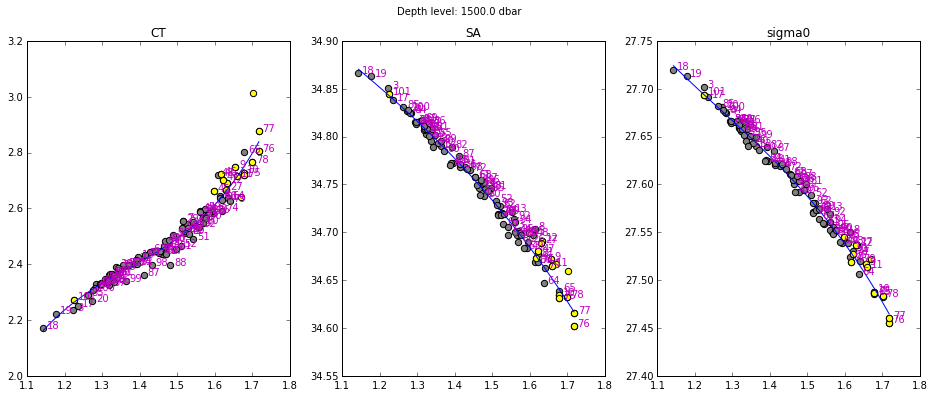

In [6]:
def label_point(x, y, val, ax):
    for ix, iy, ival in zip(x, y, val):
        if not any(np.isnan([ix, iy, ival])):
            ax.text(ix+0.01, iy, str(ival), color='m')

plvls = np.linspace(100, 1500, 15)
for p in plvls:
    fig, ax = plt.subplots(1, 3, figsize=(16,6))
    for axis, var in enumerate(vars):
        ax[axis].scatter(D[2:], ctd[var][2:, pressure_levels[p]], s=40, facecolors='gray')
        ax[axis].scatter(D[iodds], ctd[var][iodds, pressure_levels[p]], s=40, facecolors='yellow')
        ax[axis].plot(xinterp, splines[p][var](xinterp))
        label_point(D[2:], ctd[var][2:, pressure_levels[p]], ctd['station'][2:], ax=ax[axis])
        ax[axis].set_title(var)

    fig.suptitle('Depth level: %s dbar' % p)


Plot the outliers on a map and compare to interpolated dynamic height contours.

/home/janjaapmeijer/miniconda3/envs/ocean3/lib/python3.5/site-packages/numpy/ma/core.py:6385: MaskedArrayFutureWarning: In the future the default for ma.minimum.reduce will be axis=0, not the current None, to match np.minimum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
/home/janjaapmeijer/miniconda3/envs/ocean3/lib/python3.5/site-packages/numpy/ma/core.py:6385: MaskedArrayFutureWarning: In the future the default for ma.maximum.reduce will be axis=0, not the current None, to match np.maximum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)


<a list of 7 text.Text objects>

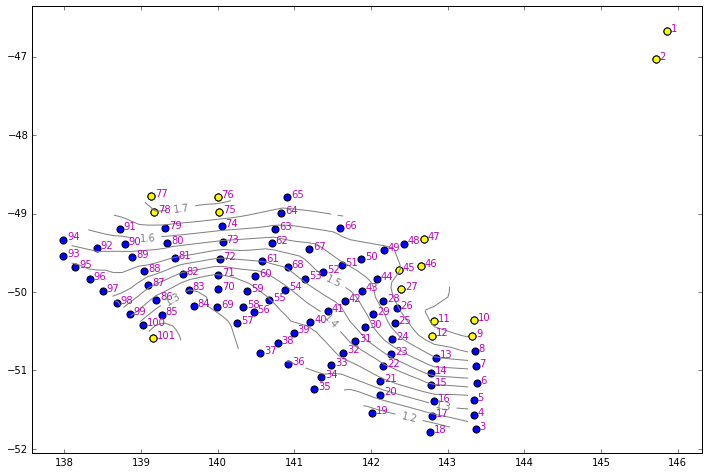

In [7]:
points = list(zip(ctd['lon'][2:, 1], ctd['lat'][2:, 1]))
lni = np.linspace(min(ctd['lon'][2:, 1]), max(ctd['lon'][2:, 1]))
lti = np.linspace(min(ctd['lat'][2:, 1]), max(ctd['lat'][2:, 1]))
lnln, ltlt = np.meshgrid(lni, lti)

interp = LinearNDInterpolator(points, D[2:])
DD = interp(lnln, ltlt)

fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(ctd['lon'][:, 1], ctd['lat'][:, 1], s=50)
ax.scatter(ctd['lon'][iodds, 1], ctd['lat'][iodds, 1], s=50, c='yellow')

for ix, iy, ival in zip(ctd['lon'][:, 1], ctd['lat'][:, 1], ctd['station'][:]):
    if not any(np.isnan([ix, iy, ival])):
        ax.text(ix+0.05, iy, str(ival), color='m')

Dcontours = np.linspace(1.2, 1.7, 11)
cont = ax.contour(lnln, ltlt, DD, Dcontours, colors='gray')
ax.clabel(cont, Dcontours[::2], inline=1, fmt='%.1f')


Create GEM

In [8]:
GEM = {}
for var in vars:
    GEM[var] = np.ma.masked_all((ctd.dimensions['profile'].size, ctd.dimensions['plevel'].size))
    for ip, p in enumerate(ctd['p']):
        try:
            for id, d in enumerate(D):
                GEM[var][id, ip] = float(splines[p][var](d))
        except TypeError:
            pass

Plot measurements and GEM of Conservative Temperature and Absolute Salinity for several depth levels.

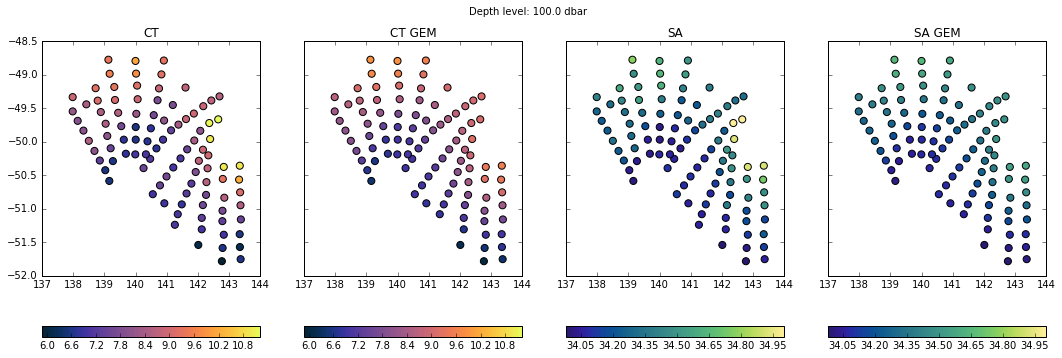

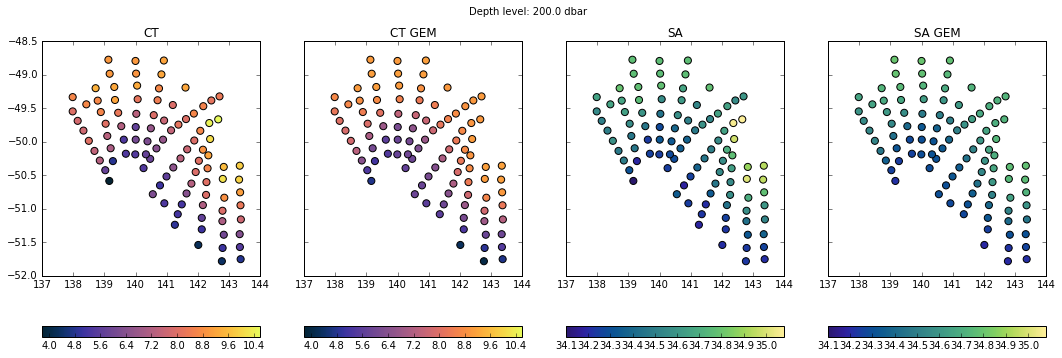

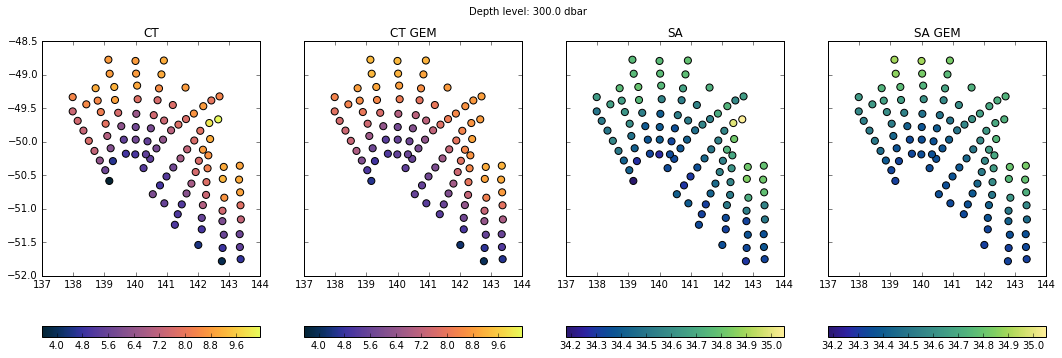

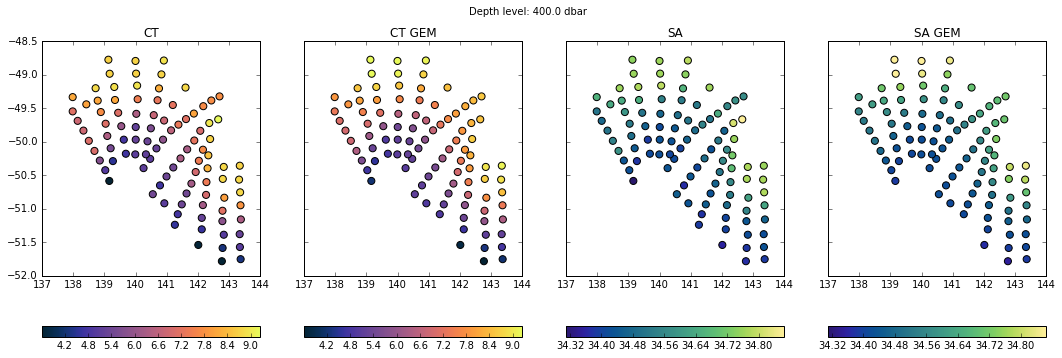

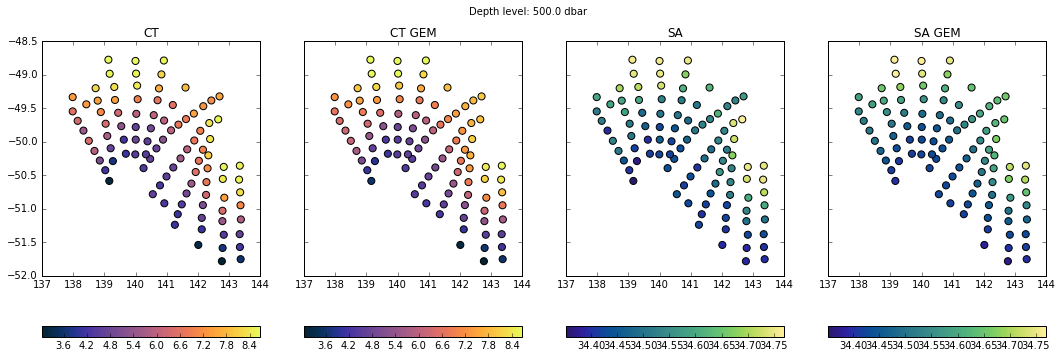

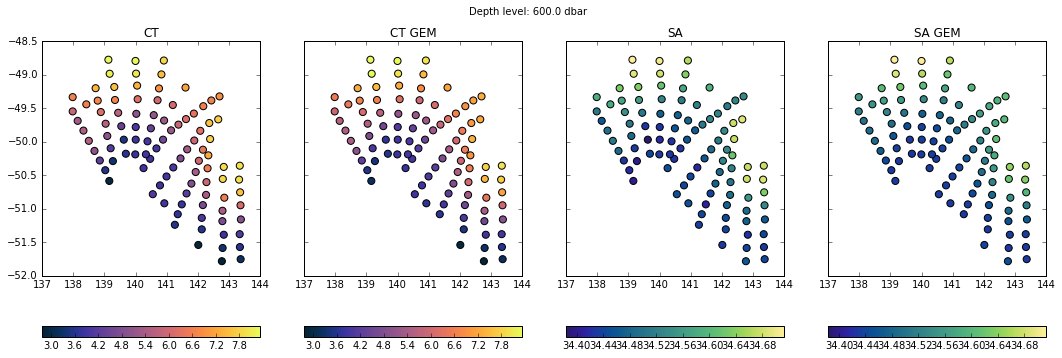

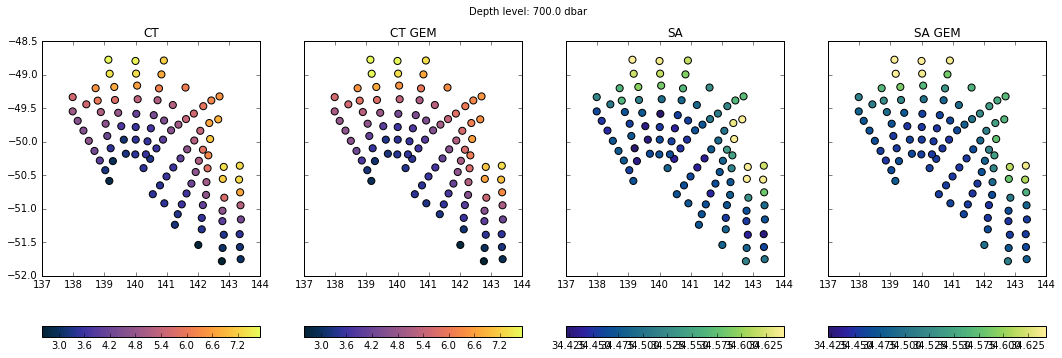

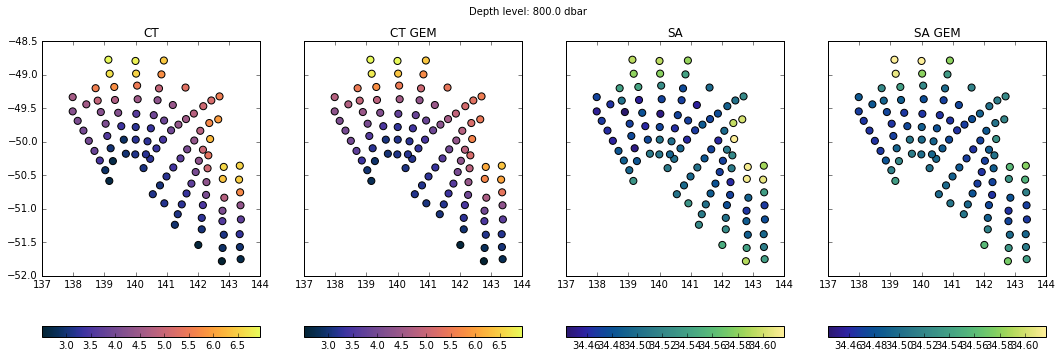

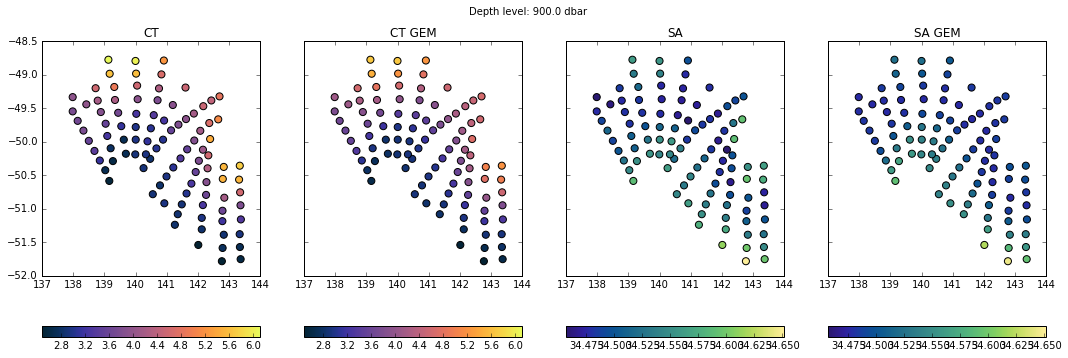

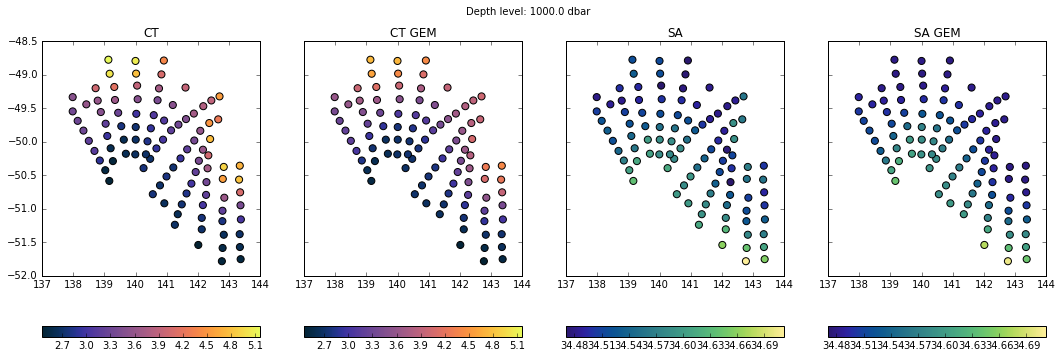

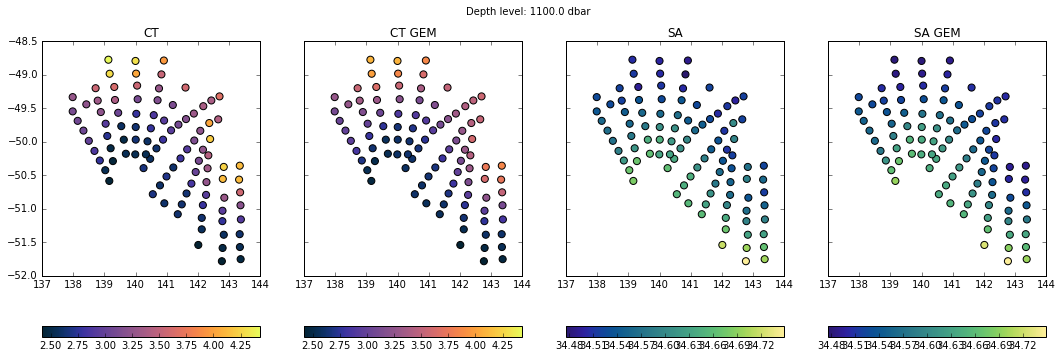

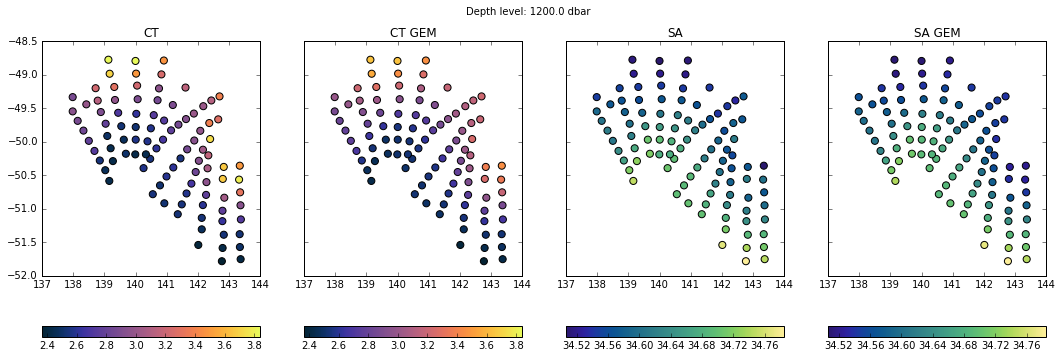

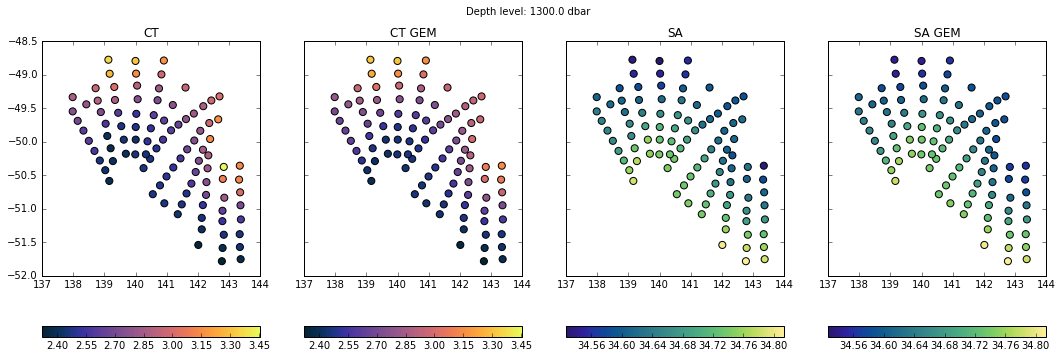

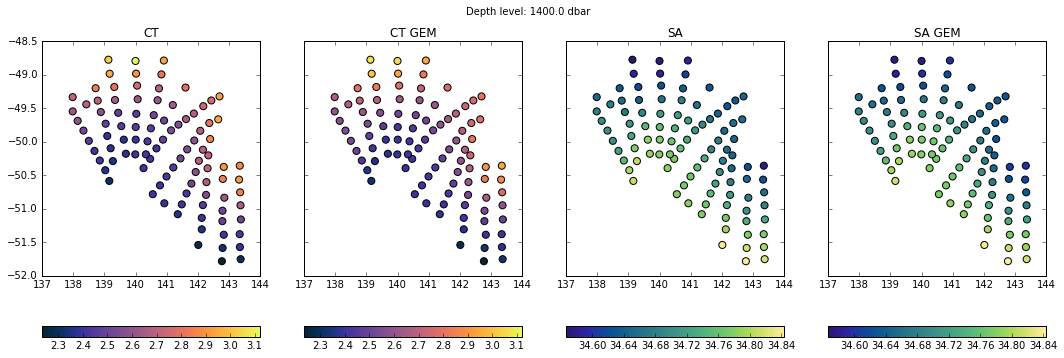

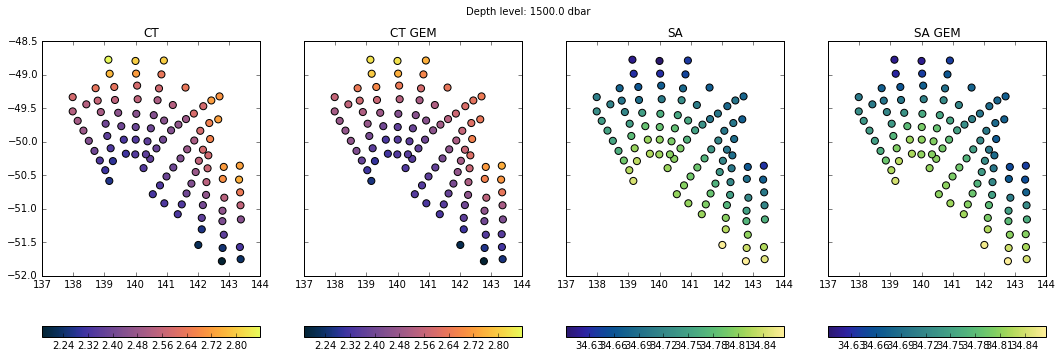

In [9]:
plvls = np.linspace(100, 1500, 15)
cmaps = {'CT': cmo.cm.thermal, 'SA': cmo.cm.haline, 'sigma0': cmo.cm.dense}
for p in plvls:
    fig, ax = plt.subplots(1, 4, figsize=(18,6), sharex=True, sharey=True)
    for axis, var in zip(range(0, 3, 2), sorted(cmaps.keys())):
#         print(axis, var)
        scat = ax[axis].scatter(ctd['lon'][2:, 1], ctd['lat'][2:, 1], c=ctd[var][2:, pressure_levels[p]], cmap=cmaps[var], s=50)
        plt.colorbar(scat, ax=ax[axis], orientation='horizontal')
        ax[axis].set_title(var)

        vmin, vmax = scat.get_clim()
        scat = ax[axis+1].scatter(ctd['lon'][2:, 1], ctd['lat'][2:, 1], c=GEM[var][2:, pressure_levels[p]], cmap=cmaps[var], vmin=vmin, vmax=vmax, s=50)
        plt.colorbar(scat, ax=ax[axis+1], orientation='horizontal')
        ax[axis+1].set_title(var + ' GEM')
    fig.suptitle('Depth level: %s dbar' % p)

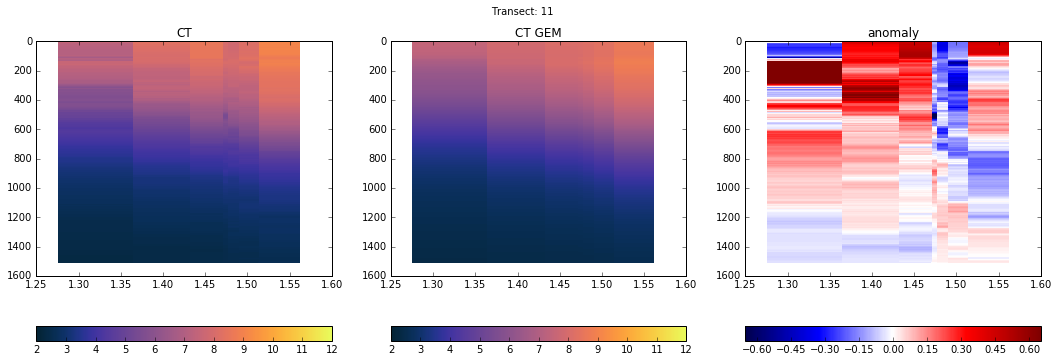

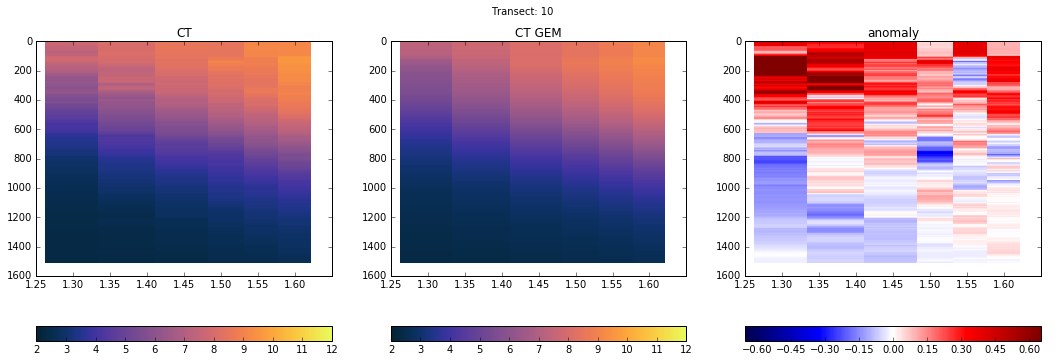

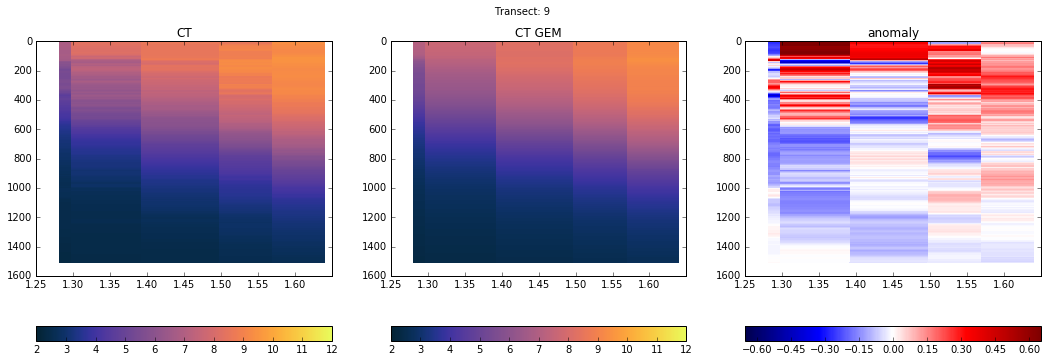

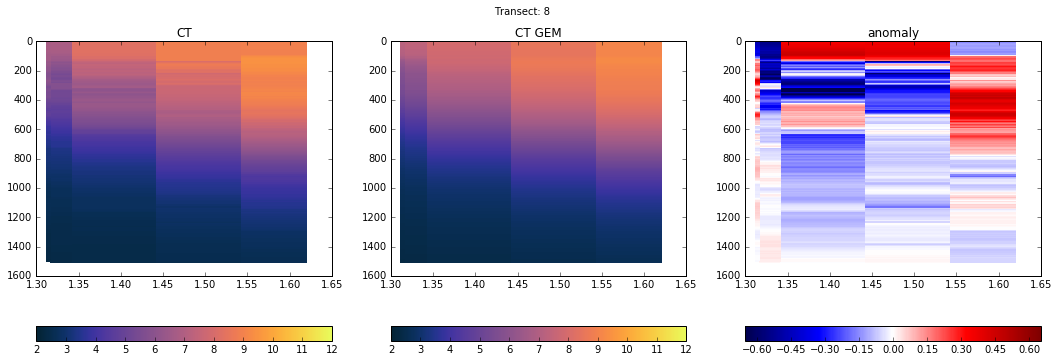

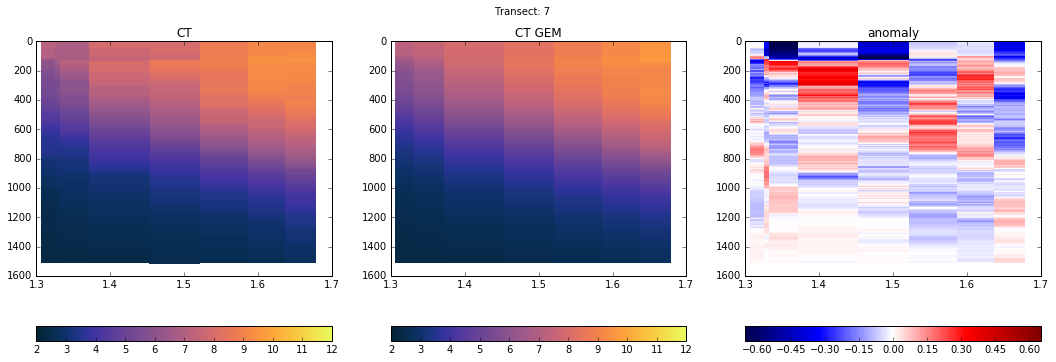

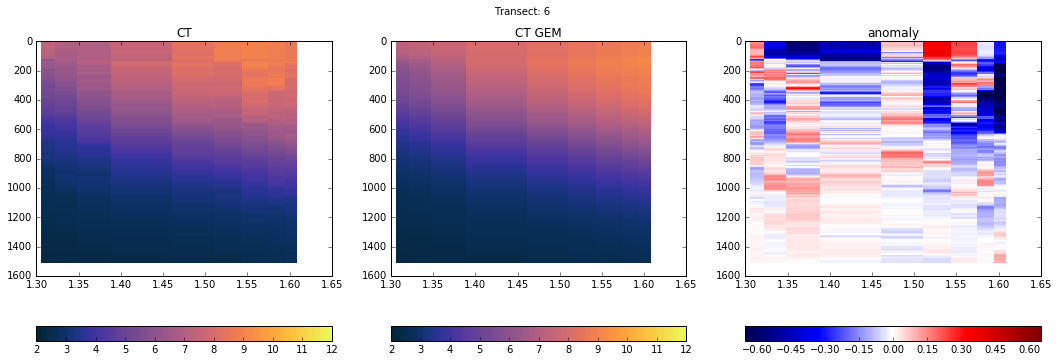

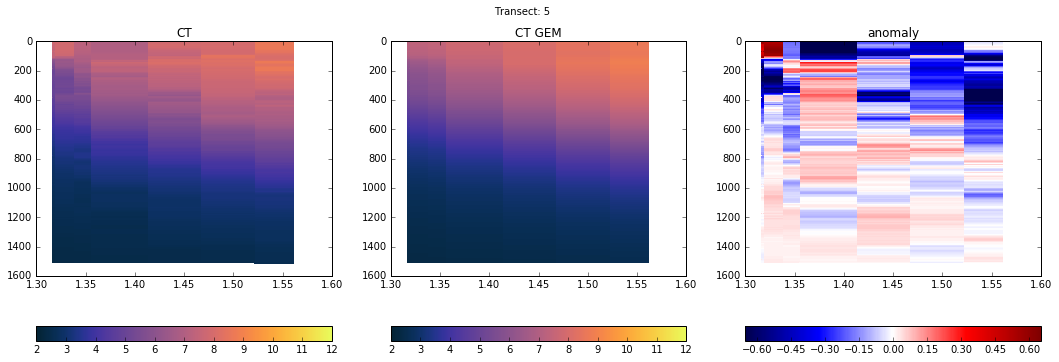

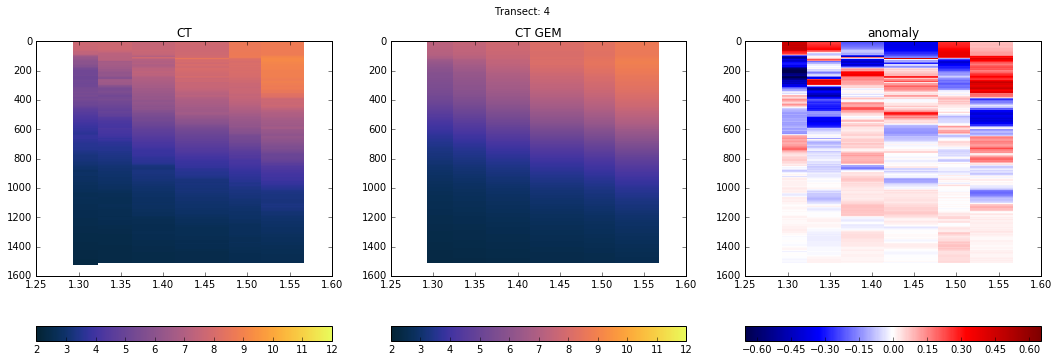

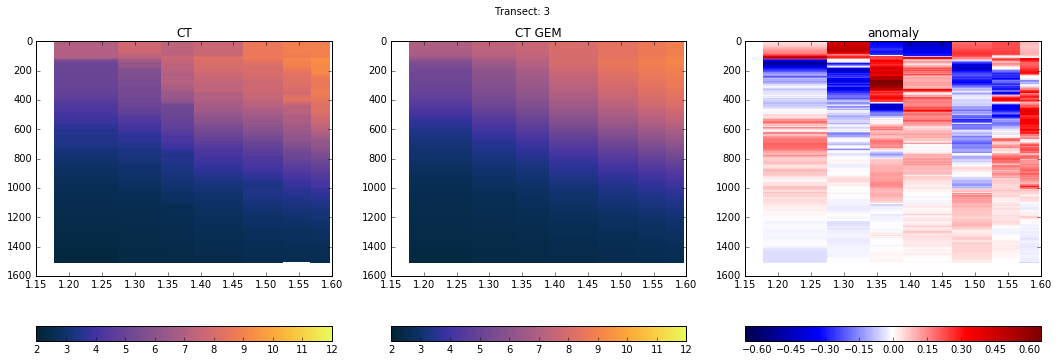

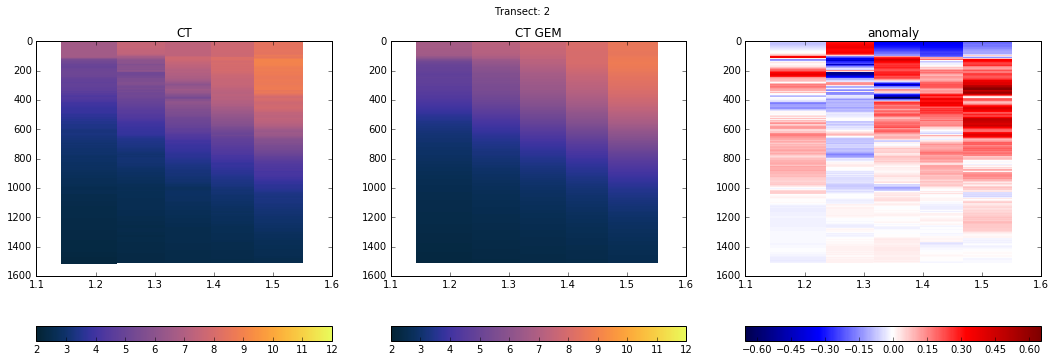

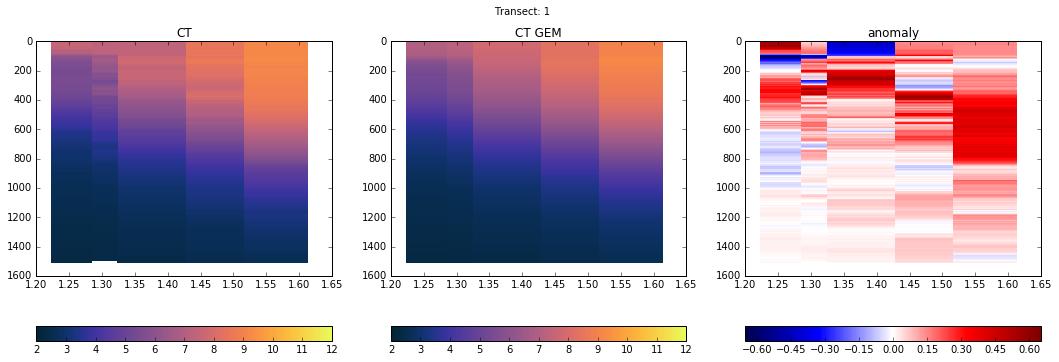

In [11]:
# transect stations
# transects = {1: list(reversed(range(2, 10))), 2: list(range(10, 18)), 3: list(reversed(range(18, 27))),
#              4: list(range(26, 34)), 5: list(reversed(range(36, 46))), 6: list(range(46, 57)),
#              7: list(reversed(range(56, 65))), 8: list(reversed(range(68, 76))), 9: list(range(76, 84)),
#              10: list(reversed(range(84, 91))), 11: list([93, 92] + list(range(94, 101)))}

transects = {1: list(reversed(range(2, 8))), 2: list(range(12, 18)), 3: list(reversed(range(18, 26))),
             4: list(range(27, 34)), 5: list(reversed(range(36, 44))), 6: list(range(47, 57)),
             7: list(reversed(range(56, 65))), 8: list(reversed(range(68, 74))), 9: list(range(78, 84)),
             10: list(reversed(range(84, 91))), 11: list([93, 92] + list(range(94, 100)))}

var = 'CT'
vert_coord = ctd['p']
titles = [var, var + ' GEM', 'anomaly']
vlim = {'CT': (2, 12), 'SA': (34, 35), 'sigma0': (26.4, 27.7)}
vlim_anom = {'CT': (-0.65, 0.65, 14), 'SA': (-0.3, 0.3, 16), 'sigma0': (-0.05, 0.05, 16)}

for transect in reversed(list(transects.keys())):
    stations = transects[transect]  
    
    fig, ax = plt.subplots(1, 3, figsize=(18, 6))
    pcol = ax[0].pcolor(D[stations], vert_coord, ctd[var][stations].T, 
                        vmin=vlim[var][0], vmax=vlim[var][1], cmap=cmaps[var])
    plt.colorbar(pcol, ax=ax[0], orientation='horizontal')
    
    pcol1 = ax[1].pcolor(D[stations], vert_coord, GEM[var][stations].T, 
                         vmin=vlim[var][0], vmax=vlim[var][1], cmap=cmaps[var])
    plt.colorbar(pcol1, ax=ax[1], orientation='horizontal')
    
    pcol2 = ax[2].pcolor(D[stations], vert_coord, ctd[var][stations].T - GEM[var][stations].T, 
                        cmap=plt.cm.seismic, vmin=vlim_anom[var][0], vmax=vlim_anom[var][1])
#     pcol2 = ax[2].pcolor(D[stations], vert_coord, GEM['sigma0'][stations].T, 
#                         cmap=cmaps['sigma0'], vmin=vlim['sigma0'][0], vmax=vlim['sigma0'][1])
    plt.colorbar(pcol2, ax=ax[2], orientation='horizontal')
   
    for axis in range(len(ax)):
        ax[axis].set_title(titles[axis])
        ax[axis].invert_yaxis()
    fig.suptitle('Transect: %s' % transect)


/home/janjaapmeijer/miniconda3/envs/ocean3/lib/python3.5/site-packages/numpy/ma/core.py:2380: RuntimeWarning: invalid value encountered in greater
  a = np.array(a, copy=copy, subok=True)


/home/janjaapmeijer/miniconda3/envs/ocean3/lib/python3.5/site-packages/matplotlib/colors.py:581: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


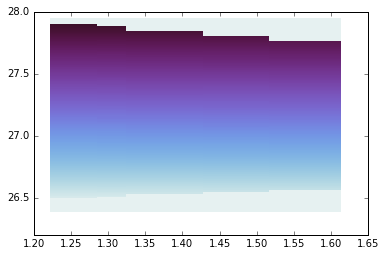

In [12]:
from scipy.interpolate import griddata
import matplotlib.colors as colors

gamman = np.ma.masked_invalid(ctd['gamman'])
gammani = np.linspace(gamman.min(), gamman.max(), ctd['p'].size)

stations = transects[1]
Dgrd, gammangrd = np.meshgrid(D[stations], gammani)
Dgrd, gammangrd = Dgrd.T, gammangrd.T

mask = ctd['sigma0'][stations].mask
sigmagrd = griddata(list(zip(Dgrd[~mask].flatten(), gamman[stations][~mask].flatten())), 
                    ctd['sigma0'][stations][~mask].flatten(), (Dgrd, gammangrd))

plt.pcolor(Dgrd, gammangrd, sigmagrd, cmap=cmaps['sigma0'], vmin=vlim['sigma0'][0], vmax=vlim['sigma0'][1])

# bounds = np.linspace(vlim['sigma0'][0], vlim['sigma0'][1], 10)
# norm = colors.BoundaryNorm(boundaries=bounds, ncolors=100)
# plt.pcolor(Dgrd, gammangrd, sigmagrd, cmap=cmaps['sigma0'], norm=norm)
# plt.colorbar()

In [13]:
for item in transects.items():
    print(item)

print(len(max(transects.items(), key=lambda x: len(x[1]))[1]))


(1, [7, 6, 5, 4, 3, 2])
(2, [12, 13, 14, 15, 16, 17])
(3, [25, 24, 23, 22, 21, 20, 19, 18])
(4, [27, 28, 29, 30, 31, 32, 33])
(5, [43, 42, 41, 40, 39, 38, 37, 36])
(6, [47, 48, 49, 50, 51, 52, 53, 54, 55, 56])
(7, [64, 63, 62, 61, 60, 59, 58, 57, 56])
(8, [73, 72, 71, 70, 69, 68])
(9, [78, 79, 80, 81, 82, 83])
(10, [90, 89, 88, 87, 86, 85, 84])
(11, [93, 92, 94, 95, 96, 97, 98, 99])
10


/home/janjaapmeijer/miniconda3/envs/ocean3/lib/python3.5/site-packages/numpy/ma/core.py:2380: RuntimeWarning: invalid value encountered in greater
  a = np.array(a, copy=copy, subok=True)
/home/janjaapmeijer/miniconda3/envs/ocean3/lib/python3.5/site-packages/numpy/ma/core.py:6385: MaskedArrayFutureWarning: In the future the default for ma.minimum.reduce will be axis=0, not the current None, to match np.minimum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
/home/janjaapmeijer/miniconda3/envs/ocean3/lib/python3.5/site-packages/numpy/ma/core.py:6385: MaskedArrayFutureWarning: In the future the default for ma.maximum.reduce will be axis=0, not the current None, to match np.maximum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)


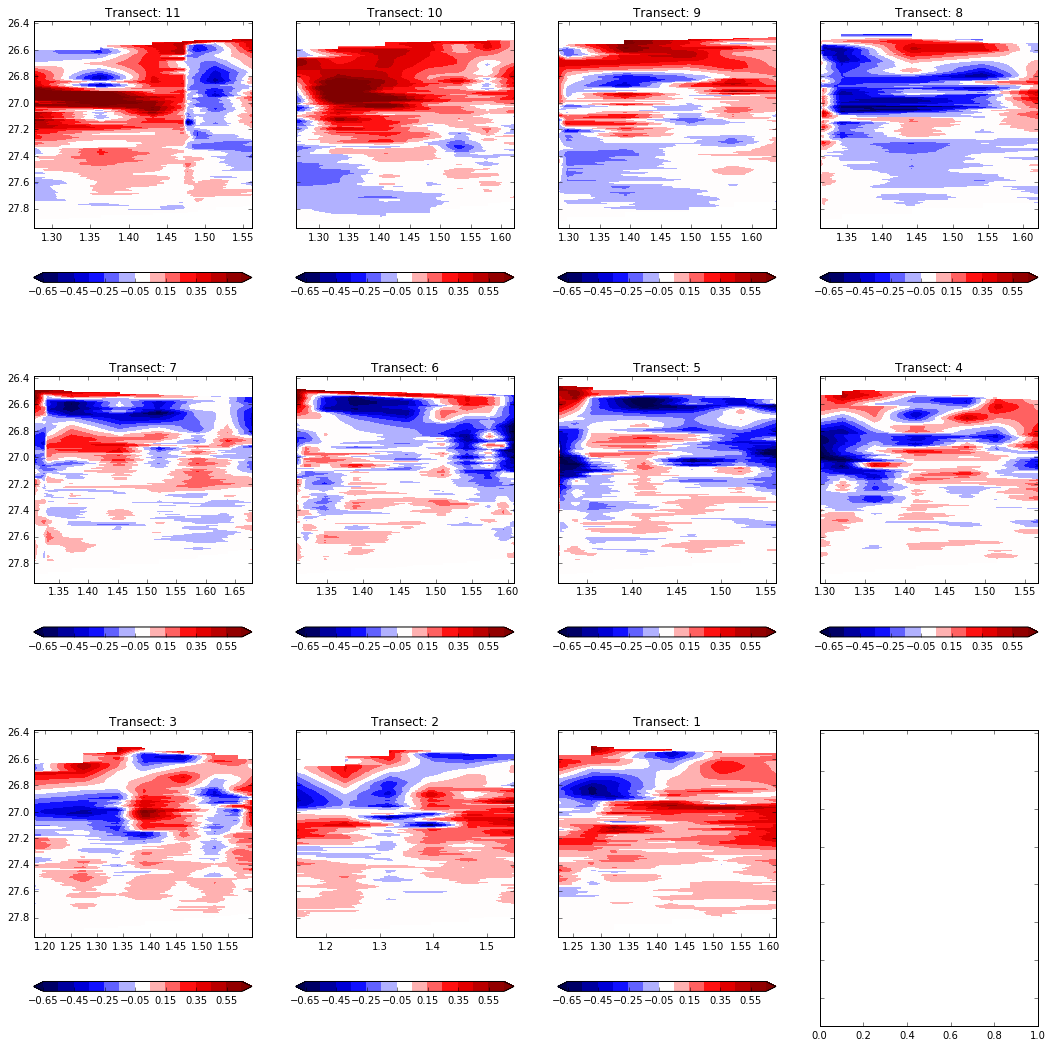

In [14]:
# interpolate
from scipy.interpolate import griddata

gamman = np.ma.masked_invalid(ctd['gamman'])
gammani = np.linspace(gamman.min(), gamman.max(), ctd['p'].size)


fig, ax = plt.subplots(3, 4, figsize=(18, 18), sharey=True)
for transect in reversed(list(transects.keys())):
    stations = transects[transect]
    
    Dgrd, gammangrd = np.meshgrid(D[stations], gammani)
    Dgrd, gammangrd = Dgrd.T, gammangrd.T
    
    # anomaly
    anomaly = ctd[var][stations] - GEM[var][stations]
#     mask = ctd['sigma0'][stations].mask
    mask = anomaly.mask
    points = list(zip(Dgrd[~mask].flatten(), gamman[stations][~mask].flatten()))
    values = anomaly[~mask].flatten()
    
#     sigmagrd = griddata(points, values, (Dgrd, gammangrd))
#     plt.pcolor(Dgrd, gammangrd, sigmagrd, cmap=cmaps['sigma0'], vmin=vlim['sigma0'][0], vmax=vlim['sigma0'][1])
    
#     xgrd, ygrd = np.meshgrid(D[stations], ctd['p'])
#     xflat, yflat = xgrd.flatten(), ygrd.flatten()
    
    # interpolate
#     anomaly_interp = griddata(list(zip(xflat, yflat)), anomaly.flatten(), (DD, pp), method='linear')
    anomaly_interp = griddata(points, values, (Dgrd, gammangrd), method='linear')

    row, col = abs(transect - 11) // 4, abs(transect - 11) % 4
#     pcol2 = ax[row, col].pcolor(D[stations], ctd['p'], anomaly, cmap=plt.cm.seismic, vmin=-0.5, vmax=0.5)
    conf = ax[row, col].contourf(Dgrd, gammangrd, anomaly_interp, 
                                 np.linspace(vlim_anom[var][0], vlim_anom[var][1], vlim_anom[var][2]), 
                                 cmap=plt.cm.seismic, extend='both')

    ax[row, col].invert_yaxis()
    ax[row, col].set_title('Transect: %s' % transect)

    plt.colorbar(conf, ax=ax[row, col], orientation='horizontal')
#     plt.colorbar(pcol2, ax=ax[2], orientation='horizontal')

/home/janjaapmeijer/miniconda3/envs/ocean3/lib/python3.5/site-packages/numpy/ma/core.py:6385: MaskedArrayFutureWarning: In the future the default for ma.minimum.reduce will be axis=0, not the current None, to match np.minimum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
/home/janjaapmeijer/miniconda3/envs/ocean3/lib/python3.5/site-packages/numpy/ma/core.py:6385: MaskedArrayFutureWarning: In the future the default for ma.maximum.reduce will be axis=0, not the current None, to match np.maximum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)


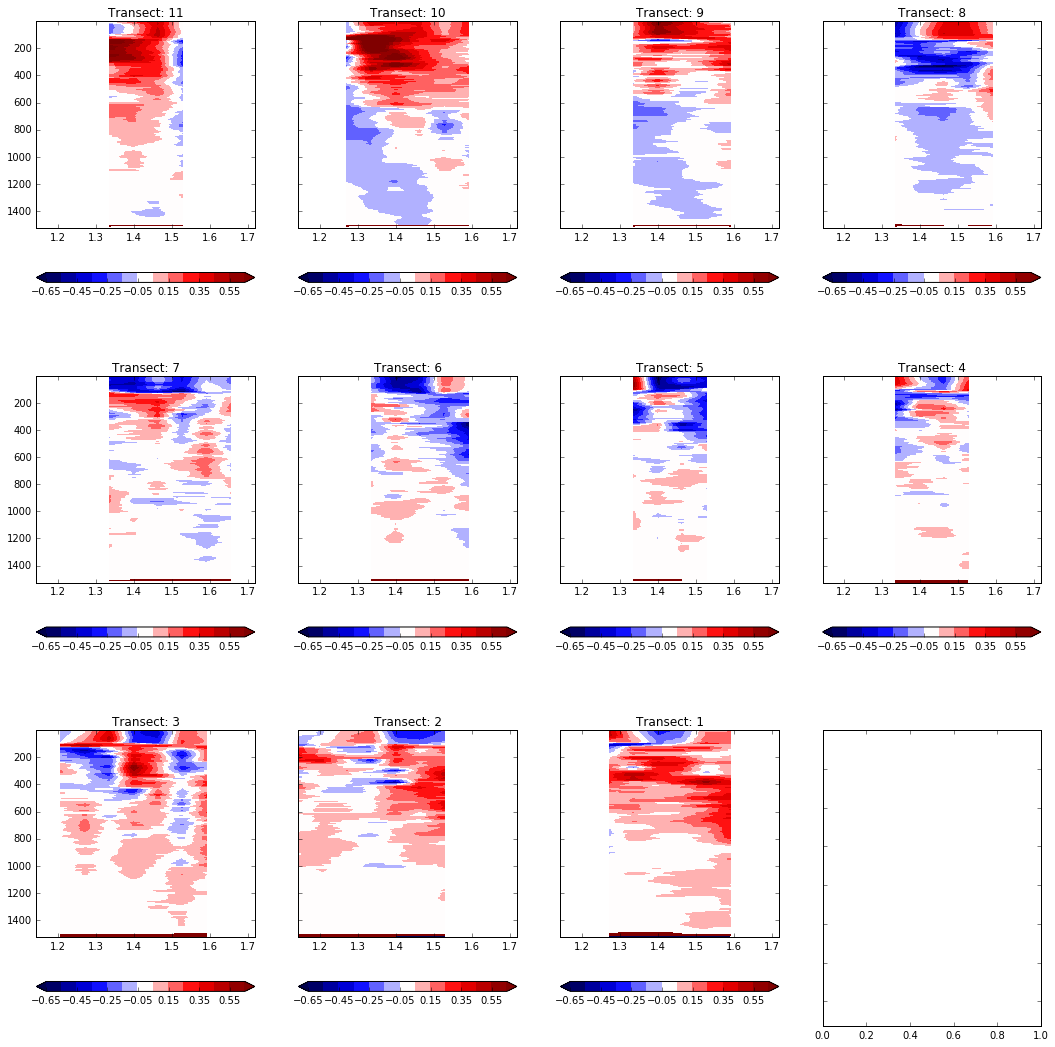

In [132]:
# interpolate
from scipy.interpolate import griddata
Di = np.linspace(np.nanmin(D), np.nanmax(D), 10)
DD, pp = np.meshgrid(Di, ctd['p'][:])

fig, ax = plt.subplots(3, 4, figsize=(18, 18), sharey=True)
for transect in reversed(list(transects.keys())):
    stations = transects[transect]
    
    xgrd, ygrd = np.meshgrid(D[stations], ctd['p'])
    xflat, yflat = xgrd.flatten(), ygrd.flatten()
    
    # anomaly
    real = griddata(list(zip(xflat, yflat)), ctd[var][stations].T.flatten(), (DD, pp), method='linear')
    gem = griddata(list(zip(xflat, yflat)), GEM[var][stations].T.flatten(), (DD, pp), method='linear')
#     anomaly = ctd[var][stations].T - GEM[var][stations].T
    
    # interpolate
#     anomaly_interp = griddata(list(zip(xflat, yflat)), anomaly.flatten(), (DD, pp), method='linear')
    anomaly_interp = real - gem

    row, col = abs(transect - 11) // 4, abs(transect - 11) % 4
#     pcol2 = ax[row, col].pcolor(D[stations], ctd['p'], anomaly, cmap=plt.cm.seismic, vmin=-0.5, vmax=0.5)
    conf = ax[row, col].contourf(DD, pp, anomaly_interp, 
                                 np.linspace(vlim_anom[var][0], vlim_anom[var][1], vlim_anom[var][2]), 
                                 cmap=plt.cm.seismic, extend='both')

    ax[row, col].invert_yaxis()
    ax[row, col].set_title('Transect: %s' % transect)

    plt.colorbar(conf, ax=ax[row, col], orientation='horizontal')
#     plt.colorbar(pcol2, ax=ax[2], orientation='horizontal')

## Mixed Layer Pressure

In [12]:
from gsw import mlp
ctd['CT']

ImportError: cannot import name 'mlp'